In [68]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

In [69]:
import lovely_tensors as lt
lt.monkey_patch()

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()
model = model.to(device)

transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [4]:
images_dir = Path('../data/example_images')
len(images_dir.ls())

50

# One image experiments

In [5]:
image = Image.open(images_dir.ls()[0])
t_image = transform(image).to(device)
batch = t_image.unsqueeze(0)
batch

tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-1.947, 2.570] μ=-0.114 σ=0.534 cuda:0

In [103]:
image.save('bird.png')

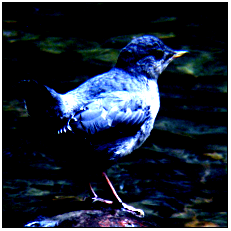

In [6]:
batch.rgb

In [91]:
def get_class_conf(model, batch):
    with torch.inference_mode():
        output = F.softmax(model(batch), dim=1)
        res_class_id = torch.argmax(output, 1)
        res_conf = output.gather(1, res_class_id[..., None])

        return res_class_id[0].item(), res_conf[0][0].item()


ref_class_id, ref_conf = get_class_conf(model, batch)
print(f"Started class was: {ref_class_id}, with confidence: {ref_conf:.6f}")

Started class was: 20, with confidence: 0.998181


## Adversarial noise optimization for as in Szegedy et al. (2013): $\text{loss}(\hat{f}(x + r), l) + c \cdot |r|$

In [7]:
eps = torch.randn(1, *batch.shape[1:], requires_grad=True, device="cuda")
eps = torch.nn.Parameter(eps)

target = torch.tensor([0])
target = torch.tensor([0], device=device)

optimizer = optim.AdamW([eps], lr=1e-3)

In [10]:
with torch.inference_mode():
    output = F.softmax(model(batch), dim=1)
    ref_class_id = torch.argmax(output, 1)
    ref_conf = output.gather(1, ref_class_id[..., None])

In [11]:
print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")

Started class was: 20, with confidence: 0.998181


In [10]:
lambda_reg = 0.01
c = lambda_reg

mseloss = torch.nn.MSELoss()

losses = []

for iteration in range(5000):
    optimizer.zero_grad()
    
    perturbed_batch = batch + eps
    perturbed_batch = torch.clamp(perturbed_batch, 0, 1)
    
    output = model(perturbed_batch)

    loss_ce = F.cross_entropy(output, target)
    
    l1_reg = torch.norm(eps, p=1)
    
    mse_loss = F.mse_loss(perturbed_batch, batch)

    loss = loss_ce + c * l1_reg + mse_loss

    losses.append({
        "ce_loss": loss_ce.item(),
        "l1_reg": l1_reg.item(),
        "mse_loss": mse_loss.item(),
        "loss": loss.item()
    })

    loss.backward()
    optimizer.step()

    with torch.inference_mode():
        eps.data = torch.clamp(batch + eps.data, 0, 1) - batch

    if iteration % 100 == 0:
        print(f"Iteration {iteration+1}, Loss: {loss.item()}, CE Loss: {loss_ce.item()}, L1 Reg: {l1_reg.item()}, MSE Loss: {mse_loss.item()}")


Iteration 1, Loss: 1207.3043212890625, CE Loss: 6.710448265075684, L1 Reg: 120014.828125, MSE Loss: 0.4455898106098175
Iteration 101, Loss: 792.9683837890625, CE Loss: 0.0017216873820871115, L1 Reg: 79252.2421875, MSE Loss: 0.4442863166332245
Iteration 201, Loss: 791.8466186523438, CE Loss: 0.0009895433904603124, L1 Reg: 79140.265625, MSE Loss: 0.4429946541786194
Iteration 301, Loss: 790.5734252929688, CE Loss: 0.0006582954083569348, L1 Reg: 79013.125, MSE Loss: 0.4415431022644043
Iteration 401, Loss: 789.177978515625, CE Loss: 0.0004864939546678215, L1 Reg: 78873.7578125, MSE Loss: 0.4399653375148773
Iteration 501, Loss: 787.676513671875, CE Loss: 0.0003828269545920193, L1 Reg: 78723.7890625, MSE Loss: 0.43827906250953674
Iteration 601, Loss: 786.0836791992188, CE Loss: 0.0003175231395289302, L1 Reg: 78564.6875, MSE Loss: 0.4365001916885376
Iteration 701, Loss: 784.4072875976562, CE Loss: 0.00027104519540444016, L1 Reg: 78397.2421875, MSE Loss: 0.434637188911438
Iteration 801, Loss: 7

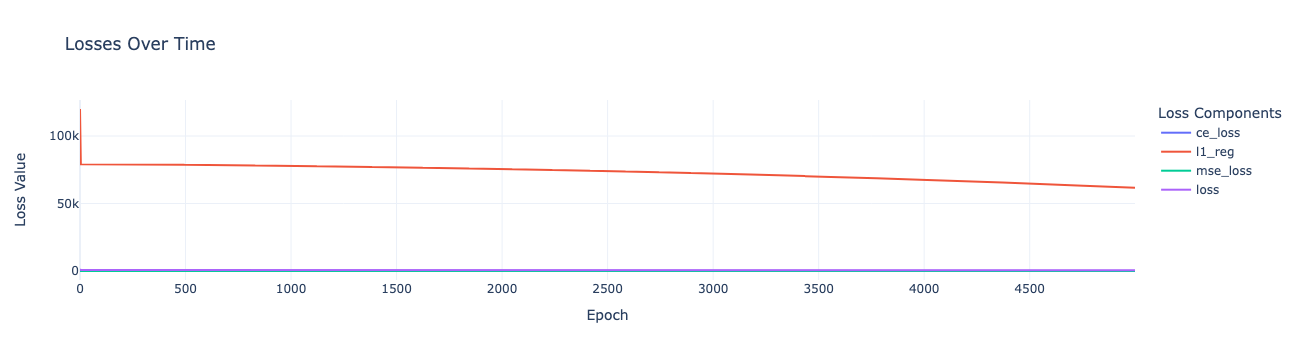

In [11]:
import plotly.graph_objects as go

def plot_losses(losses):
    data = {}
    for loss_record in losses:
        for key, value in loss_record.items():
            if key in data:
                data[key].append(value)
            else:
                data[key] = [value]
    
    fig = go.Figure()
    for key, values in data.items():
        fig.add_trace(go.Scatter(x=list(range(len(values))), y=values, mode='lines', name=key))
    
    fig.update_layout(title='Losses Over Time',
                      xaxis_title='Epoch',
                      yaxis_title='Loss Value',
                      legend_title='Loss Components',
                      # template='plotly_dark' # 'plotly', 'plotly_white'
                      template='plotly_white'
                     )
    fig.show()

plot_losses(losses)


In [12]:
with torch.inference_mode():
    output = F.softmax(model(batch + eps), dim=1)
    res_class_id = torch.argmax(output, 1)
    res_conf = output.gather(1, res_class_id[..., None])

print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")
print(f"Resulted class after adversarial noise: {res_class_id[0]}, with confidence: {res_conf[0][0]:.6f}")
print(f"Current reference confidence after adversarial noise: {ref_class_id[0]}, with confidence: {output.gather(1, ref_class_id[..., None])[0][0]:.6f}")

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 0, with confidence: 0.999967
Current reference confidence after adversarial noise: 20, with confidence: 0.000000


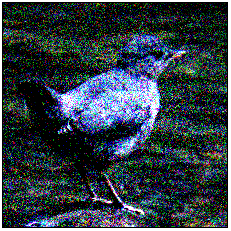

In [14]:
(batch + eps).rgb

## Goodfellow et al. (2014) Explaining and harnessing adversarial examples

In [7]:
import torch.nn as nn
def generate_adversarial_example(model, x, label, epsilon):
    # 1. Computing the Gradient
    image = x.clone()
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, torch.tensor([label]).to(device))

    model.zero_grad()
    loss.backward()

    # 2. Generating the Adversarial Example
    perturbation = epsilon * torch.sign(image.grad)
    
    # 3. Updating the Input
    adversarial_image = image + perturbation
    return adversarial_image.detach(), perturbation

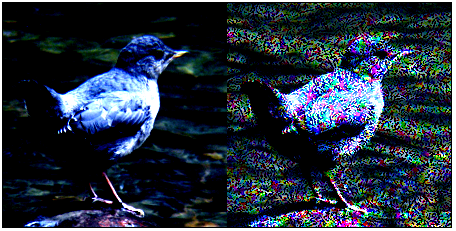

In [8]:
adv_example, pertubation = generate_adversarial_example(model, batch, 0, epsilon=0.5)
torch.cat([batch, adv_example], dim=3).rgb

In [13]:
with torch.inference_mode():
    output = F.softmax(model(pertubation), dim=1)
    res_class_id = torch.argmax(output, 1)
    res_conf = output.gather(1, res_class_id[..., None])

print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")
print(f"Resulted class after adversarial noise: {res_class_id[0]}, with confidence: {res_conf[0][0]:.6f}")
print(f"Current reference confidence after adversarial noise: {ref_class_id[0]}, with confidence: {output.gather(1, ref_class_id[..., None])[0][0]:.6f}")

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 735, with confidence: 0.047604
Current reference confidence after adversarial noise: 20, with confidence: 0.000065


### Targeted attack

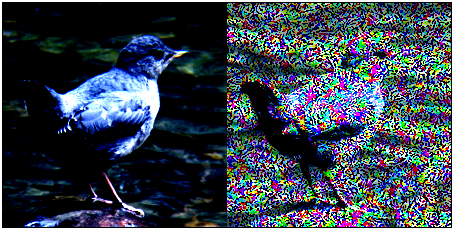

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 4, with confidence: 0.082269
Current reference confidence after adversarial noise: 20, with confidence: 0.000513


In [17]:
import torch.nn as nn
def generate_targeted_adversarial_example(model, x, label, epsilon):
    # Ensure model is in evaluation mode
    model.eval()

    # 1. Computing the Gradient
    image = x.clone().to(device)
    image.requires_grad = True
    
    # Make sure target label is a long tensor and sent to the correct device
    target = torch.tensor([label], dtype=torch.long).to(device)
    
    output = model(image)
    # Use negative log likelihood of target class to encourage model to classify as target
    loss = -F.nll_loss(F.log_softmax(output, dim=1), target)

    model.zero_grad()
    loss.backward()

    # 2. Generating the Adversarial Example
    perturbation = epsilon * torch.sign(image.grad.data)
    
    # 3. Updating the Input
    adversarial_image = image - perturbation  # Subtract to move towards target class
    adversarial_image = torch.clamp(adversarial_image, 0, 1)  # Ensure pixel values are valid

    return adversarial_image.detach(), perturbation

adv_example, pertubation = generate_targeted_adversarial_example(model, batch, 0, epsilon=0.9)
display(torch.cat([batch, adv_example], dim=3).rgb)

with torch.inference_mode():
    output = F.softmax(model(adv_example), dim=1)
    res_class_id = torch.argmax(output, 1)
    res_conf = output.gather(1, res_class_id[..., None])

print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")
print(f"Resulted class after adversarial noise: {res_class_id[0]}, with confidence: {res_conf[0][0]:.6f}")
print(f"Current reference confidence after adversarial noise: {ref_class_id[0]}, with confidence: {output.gather(1, ref_class_id[..., None])[0][0]:.6f}")

In [36]:
# Fast Gradient Singed Method attack (FGSM)
#Model is the trained model for the target dataset
#target is the ground truth label of the image
#epsilon is the hyper parameter which shows the degree of perturbation

def fgsm_attack(model, x, target, epsilon):
    # Set requires_grad attribute of tensor. Important for Attack
    image = x.clone()
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability(the prediction of the model)
    
    target = torch.tensor([target], dtype=torch.long).to(device)
   
    # If the initial prediction is already wrong, dont bother attacking
    if init_pred[0].item() != target[0].item():
    #if init_pred.item() != target.item():
        return image
    # Calculate the loss
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = image.grad.data
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

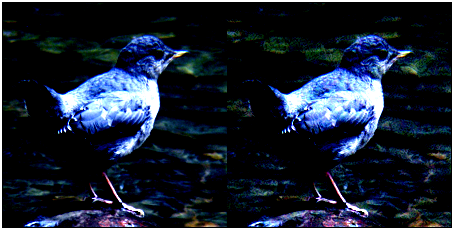

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 50, with confidence: 0.305280
Current reference confidence after adversarial noise: 20, with confidence: 0.071821


In [35]:
adv_example = fgsm_attack(model, batch, 20, epsilon=0.07)
display(torch.cat([batch, adv_example], dim=3).rgb)

with torch.inference_mode():
    output = F.softmax(model(adv_example), dim=1)
    res_class_id = torch.argmax(output, 1)
    res_conf = output.gather(1, res_class_id[..., None])

print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")
print(f"Resulted class after adversarial noise: {res_class_id[0]}, with confidence: {res_conf[0][0]:.6f}")
print(f"Current reference confidence after adversarial noise: {ref_class_id[0]}, with confidence: {output.gather(1, ref_class_id[..., None])[0][0]:.6f}")

In [42]:
# Iterative least likely method

# Model is the trained model for the target dataset
# target is the ground truth label of the image
# alpha is the hyper parameter which shows the degree of perturbation in each iteration, the value is borrowed from the refrenced paper [4] according to the report file
# iters is the no. of iterations
# no. of iterations can be set manually, otherwise (if iters==0) this function will take care of it

def ill_attack(model, x, target, epsilon, alpha, iters): 
    image = x.clone()
    # Forward passing the image through model one time to get the least likely labels
    output = model(image)
    ll_label = torch.min(output, 1)[1] # get the index of the min log-probability    
    
    if iters == 0 :
        # In paper [4], min(epsilon + 4, 1.25*epsilon) is used as number of iterations
        iters = int(min(epsilon + 4, 1.25*epsilon))

    target = torch.tensor([target], dtype=torch.long).to(device)

    
    # In the original paper the images were in [0,255] range but here our data is in [0,1].
    # So we need to scale the epsilon value in a way that suits our data, which is dividing by 255.
    epsilon = epsilon/255
    
    for i in range(iters) : 
        # Set requires_grad attribute of tensor. Important for Attack
        image.requires_grad = True
        
        # Forward pass the data through the model
        output = model(image)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability(the model's prediction)
        
        # If the current prediction is already wrong, dont bother to continue
        if init_pred.item() != target.item():
            return image

        # Calculate the loss
        loss = F.nll_loss(output, ll_label) 

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = image.grad.data

        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()
        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_image = image - alpha*sign_data_grad
        
                
        # Updating the image for next iteration
        #
        # We want to keep the perturbed image in range [image-epsilon, image+epsilon] 
        # based on the definition of the attack. However the value of image-epsilon 
        # itself must not fall behind 0, as the data range is [0,1].
        # And the value of image+epsilon also must not exceed 1, for the same reason.
        # So we clip the perturbed image between the (image-epsilon) clipped to 0 and 
        # (image+epsilon) clipped to 1.
        a = torch.clamp(image - epsilon, min=0)  
        b = (perturbed_image>=a).float()*perturbed_image + (a>perturbed_image).float()*a
        c = (b > image+epsilon).float()*(image+epsilon) + (image+epsilon >= b).float()*b
        image = torch.clamp(c, max=1).detach_()
    
    return image

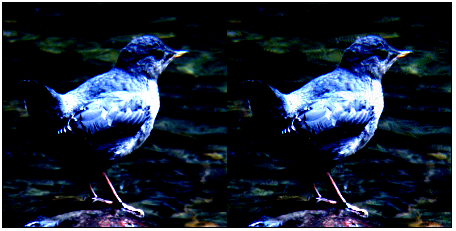

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 351, with confidence: 0.363511
Current reference confidence after adversarial noise: 20, with confidence: 0.106078


In [51]:
adv_example = ill_attack(model, batch, 20, epsilon=2, alpha=0.7, iters=1000)
display(torch.cat([batch, adv_example], dim=3).rgb)

with torch.inference_mode():
    output = F.softmax(model(adv_example), dim=1)
    res_class_id = torch.argmax(output, 1)
    res_conf = output.gather(1, res_class_id[..., None])

print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")
print(f"Resulted class after adversarial noise: {res_class_id[0]}, with confidence: {res_conf[0][0]:.6f}")
print(f"Current reference confidence after adversarial noise: {ref_class_id[0]}, with confidence: {output.gather(1, ref_class_id[..., None])[0][0]:.6f}")

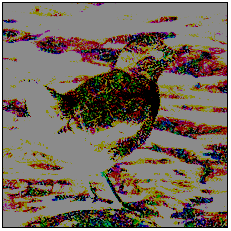

In [60]:
((adv_example - batch)*10).rgb

  0%|          | 0/1000 [00:00<?, ?it/s]

Target class confidence tensor[1] cuda:0 [0.000]
Target class confidence tensor[1] cuda:0 [0.004]
Target class confidence tensor[1] cuda:0 [0.005]
Target class confidence tensor[1] cuda:0 [0.008]
Target class confidence tensor[1] cuda:0 [0.024]
Target class confidence tensor[1] cuda:0 [0.024]
Target class confidence tensor[1] cuda:0 [0.045]
Target class confidence tensor[1] cuda:0 [0.007]
Target class confidence tensor[1] cuda:0 [0.031]
Target class confidence tensor[1] cuda:0 [0.005]


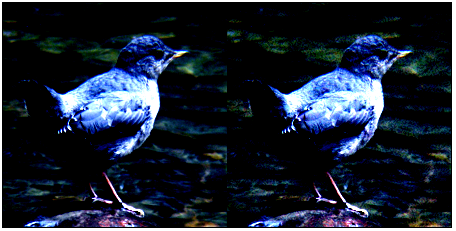

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 394, with confidence: 0.827837
Current reference confidence after adversarial noise: 20, with confidence: 0.000001


In [78]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

def perform_ill_attack(model, input_image, target_class, epsilon, alpha, num_iterations):
    """
    Generates an adversarial image that is classified as the specified target class by the model.
    
    Args:
    - model: The trained model.
    - input_image: The original image.
    - target_class: The desired target class for the model to misclassify the adversarial image as.
    - epsilon: The maximum disturbance allowed.
    - alpha: Step size for gradient update.
    - num_iterations: Number of iterations for the attack. Calculated based on epsilon if set to 0.
    
    Returns:
    - A tensor representing the adversarial image.
    """
    perturbed_image = input_image.clone()
    if num_iterations == 0:
        num_iterations = int(min(epsilon + 4, 1.25 * epsilon))

    target_tensor = torch.tensor([target_class], dtype=torch.long, device=input_image.device)
    epsilon_scaled = epsilon / 255.0

    for i in tqdm(list(range(num_iterations))):
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        loss = F.cross_entropy(output, target_tensor)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            perturbed_image -= alpha * perturbed_image.grad.sign()
            perturbed_image = torch.clamp(perturbed_image, input_image - epsilon_scaled, input_image + epsilon_scaled)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
            
            # Check if the adversarial goal is achieved early
            output = model(perturbed_image)
            final_pred = output.max(1, keepdim=True)[1]
            # if final_pred.item() == target_class:
            #     break

            if i % 100 == 0:
                print(f"Target class confidence {F.softmax(output, dim=1)[:, target_class]}")

    return perturbed_image.detach()

adv_example = perform_ill_attack(model, batch, 0, epsilon=16, alpha=2, num_iterations=1000)
display(torch.cat([batch, adv_example], dim=3).rgb)

with torch.inference_mode():
    output = F.softmax(model(adv_example), dim=1)
    res_class_id = torch.argmax(output, 1)
    res_conf = output.gather(1, res_class_id[..., None])

print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")
print(f"Resulted class after adversarial noise: {res_class_id[0]}, with confidence: {res_conf[0][0]:.6f}")
print(f"Current reference confidence after adversarial noise: {ref_class_id[0]}, with confidence: {output.gather(1, ref_class_id[..., None])[0][0]:.6f}")


In [65]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

def attack(model, input_image, target_class, epsilon, num_iterations):
    perturbed_image = input_image.clone()
    
    target_tensor = torch.tensor([target_class], dtype=torch.long, device=input_image.device)

    for i in tqdm(list(range(num_iterations))):
        # Fitting something...
        
    return perturbed_image.detach()

adv_example = attack(model, batch, 0, epsilon=16, num_iterations=1000)
display(torch.cat([batch, adv_example], dim=3).rgb)

with torch.inference_mode():
    output = F.softmax(model(adv_example), dim=1)
    res_class_id = torch.argmax(output, 1)
    res_conf = output.gather(1, res_class_id[..., None])

print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")
print(f"Resulted class after adversarial noise: {res_class_id[0]}, with confidence: {res_conf[0][0]:.6f}")
print(f"Current reference confidence after adversarial noise: {ref_class_id[0]}, with confidence: {output.gather(1, ref_class_id[..., None])[0][0]:.6f}")


tensor[1] cuda:0 [0.004]

## Target attack

  0%|          | 0/1000 [00:00<?, ?it/s]

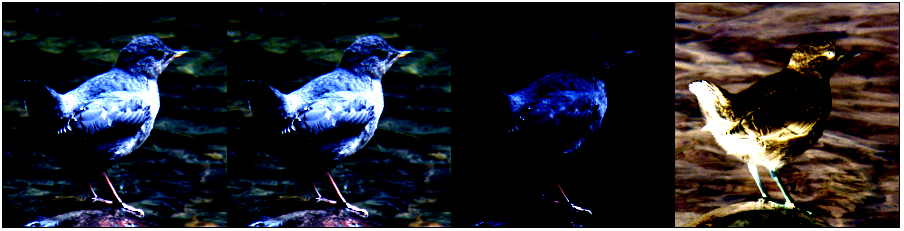

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 111, with confidence: 0.298783


In [266]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

def attack(model, input_image, target_class, epsilon, num_iterations, lambda_reg=0.05):
    perturbed_image = input_image.clone().detach().requires_grad_(True)
    target_tensor = torch.tensor([target_class], dtype=torch.long, device=input_image.device)

    epsilon = epsilon / 255.0  # Adjust epsilon value to [0,1] scale

    for _ in tqdm(range(num_iterations)):
        model.zero_grad()

        output = model(perturbed_image)
        loss_adv = F.cross_entropy(output, target_tensor)
        
        loss_reg = lambda_reg * F.mse_loss(perturbed_image, input_image)
        loss = loss_adv + loss_reg

        loss.backward()

        sign_data_grad = perturbed_image.grad.data.sign()

        perturbed_image.data = perturbed_image.data - epsilon * sign_data_grad

        perturbed_image.data = torch.clamp(perturbed_image.data, 0, 1)

        perturbed_image.grad.data.zero_()

        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability(the model's prediction)
        # If the current prediction is already wrong, dont bother to continue
        if init_pred.item() == target_tensor.item():
            return perturbed_image.detach()
        
    return perturbed_image.detach()

adv_example = attack(model, batch, 111, epsilon=0.007, num_iterations=1000, lambda_reg=0.05)

bdiff = batch - adv_example
adiff = adv_example - batch

display(torch.cat([batch, adv_example, bdiff, adiff], dim=3).rgb)

ref_class_id, ref_conf = get_class_conf(model, batch)
print(f"Started class was: {ref_class_id}, with confidence: {ref_conf:.6f}")

res_class_id, res_conf = get_class_conf(model, adv_example)
print(f"Resulted class after adversarial noise: {res_class_id}, with confidence: {res_conf:.6f}")

### Analyze activation path

In [267]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [268]:
image = adv_example.clone()#batch.clone()

In [269]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [270]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


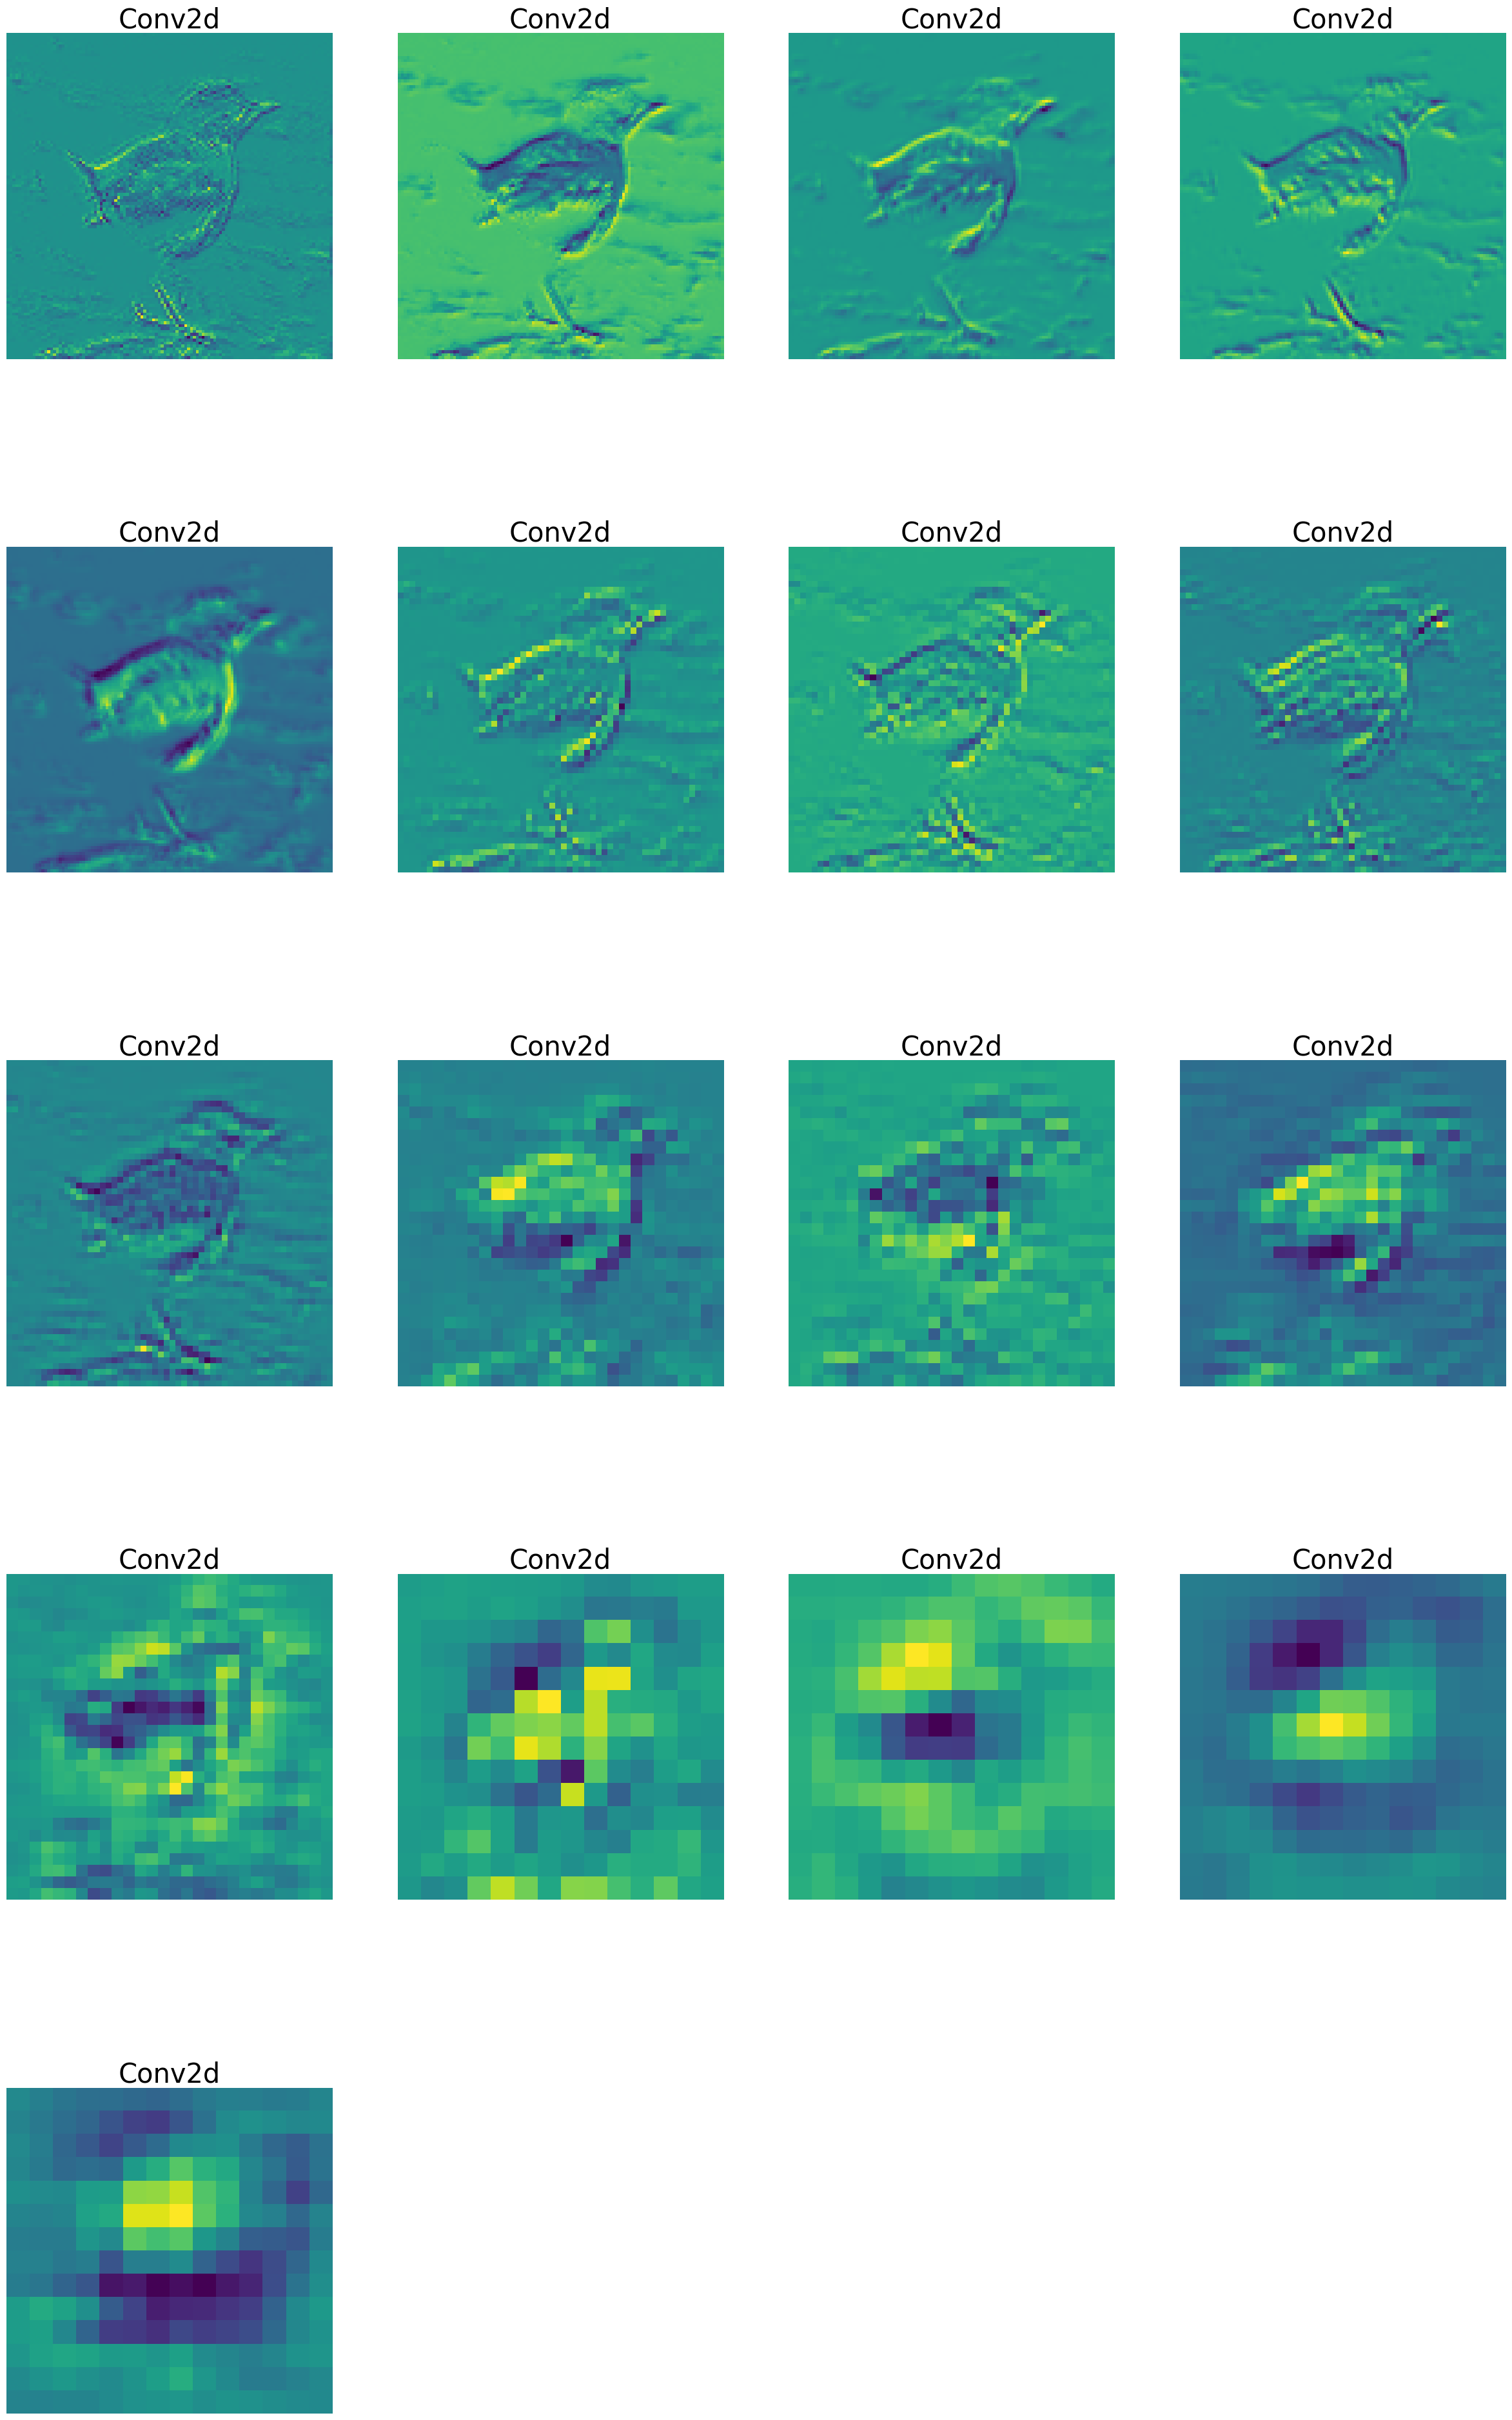

In [271]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

### GradCAM

To visualize why a model classifies an adversarial example as a particular target class, you can use techniques that highlight the parts of the image that were most influential in the model's decision. One popular method for doing this is Gradient-weighted Class Activation Mapping (Grad-CAM). Grad-CAM uses the gradients of the target concept (in this case, the target class for the adversarial example) flowing into the final convolutional layer of the model to produce a coarse localization map. This map highlights the important regions in the image for predicting the class.

Below, I'll guide you through implementing Grad-CAM for a PyTorch model. This example assumes you have a convolutional neural network model and an adversarial example for which you want to visualize the class activation map.

In [272]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()
model = model.to(device)

In [273]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None
        
        # Remove any existing hooks to avoid conflicts
        self.clear_hooks()

        # Register forward and backward hooks
        self.forward_hook = target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = target_layer.register_full_backward_hook(self.save_gradients)

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def save_activation(self, module, input, output):
        self.activation = output

    def clear_hooks(self):
        # Clear existing forward hooks
        for k in list(self.target_layer._forward_hooks.keys()):
            del self.target_layer._forward_hooks[k]
        
        # Clear existing backward hooks
        for k in list(self.target_layer._backward_hooks.keys()):
            del self.target_layer._backward_hooks[k]

    def __call__(self, x, index=None):
        output = self.model(x)
        if index is None:
            index = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output).to(x.device)
        one_hot[range(x.shape[0]), index] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        if self.gradients.dim() == 4:  # Expected dimensionality for convolutional layers
            gradients = self.gradients.mean(dim=[2, 3], keepdim=True)
        else:
            raise ValueError("Unexpected gradient dimensionality")

        activation = F.relu((gradients * self.activation).sum(dim=1)).squeeze()
        return activation

    def __del__(self):
        # Make sure to remove hooks when the GradCAM instance is deleted
        self.forward_hook.remove()
        self.backward_hook.remove()


def show_cam_on_image(img, mask):
    heatmap = np.uint8(255 * mask)  # Convert to uint8
    plt.imshow(img.permute(1, 2, 0).cpu())  # Assuming img is [C, H, W]
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Add heatmap overlay
    plt.show()

In [274]:
def show_gradcam(model, target_layer, image):
    model.eval()  # Ensure the model is in evaluation mode
    grad_cam = GradCAM(model, target_layer)
    activation_map = grad_cam(image)  # Assuming adversarial_example is correctly processed
    
    # Rescale the activation map to fit the image size
    activation_map_resized = torch.nn.functional.interpolate(activation_map.unsqueeze(0).unsqueeze(0), size=image.size()[2:], mode='bilinear', align_corners=False).squeeze()
    
    show_cam_on_image(image[0], activation_map_resized.detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


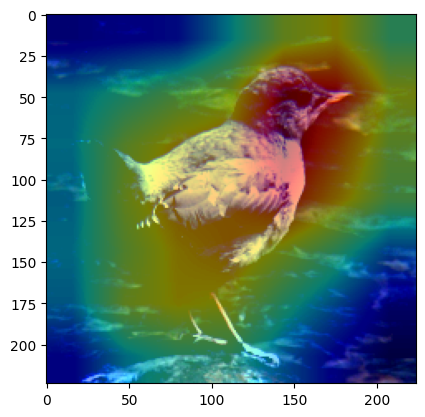

In [275]:
show_gradcam(model, model.layer4[1], batch.detach())

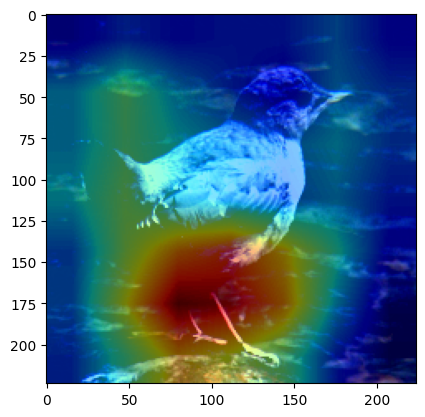

In [276]:
show_gradcam(model, model.layer4[1], adv_example.detach())

## Patch based attack

  0%|          | 0/1000 [00:00<?, ?it/s]

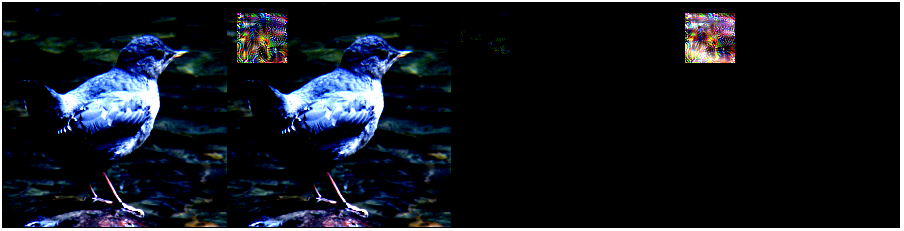

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 0, with confidence: 0.984944


In [262]:
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import normalize, resize
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

def attack(model, input_image, target_class, epsilon, num_iterations, alpha=1e-2):
    # Assuming input_image is normalized
    
    # Initialize a patch with random noise
    patch_size = 50  # Patch size
    start_x, start_y = 10, 10  # Adjust as needed
    patch = input_image[:, :, start_x:start_x+patch_size, start_y:start_y+patch_size].clone().contiguous().detach()
    patch.requires_grad=True
    
    # Dimensions of the input image
    b, img_c, img_h, img_w = input_image.shape
    
    # Starting position for the patch (upper left corner)
    
    
    # Ensure the patch doesn't exceed image dimensions
    assert start_x + patch_size <= img_h and start_y + patch_size <= img_w, "Patch goes beyond image bounds."
    
    # Target class tensor
    target_tensor = torch.tensor([target_class] * b, dtype=torch.long, device=input_image.device)
    
    optimizer = torch.optim.Adam([patch], lr=alpha)
    
    for _ in tqdm(range(num_iterations)):
        optimizer.zero_grad()
        
        # Create a new copy of the image for each iteration
        perturbed_image = input_image.clone()
        
        # Insert the patch into the copied image
        perturbed_image[:, :, start_x:start_x+patch_size, start_y:start_y+patch_size] = patch
        
        # Get model predictions and calculate loss
        output = model(perturbed_image)
        
        loss_adv = F.cross_entropy(output, target_tensor)
        loss_reg = F.mse_loss(patch, perturbed_image[:, :, start_x:start_x+patch_size, start_y:start_y+patch_size])
        loss = (loss_adv + loss_reg)
        
        # Backpropagate loss to adjust the patch
        loss.backward()
        optimizer.step()
        
        # Ensure patch values stay within valid range
        patch.data.clamp_(0, 1)
    
    # Apply the final adjusted patch to the original image
    final_image = input_image.clone()
    final_image[:, :, start_x:start_x+patch_size, start_y:start_y+patch_size] = patch.detach()
    
    return final_image

adv_example = attack(model, batch, 0, epsilon=16, num_iterations=1000, alpha=1e-2)
bdiff = batch - adv_example
adiff = adv_example - batch

display(torch.cat([batch, adv_example, bdiff, adiff], dim=3).rgb)

ref_class_id, ref_conf = get_class_conf(model, batch)
print(f"Started class was: {ref_class_id}, with confidence: {ref_conf:.6f}")

res_class_id, res_conf = get_class_conf(model, adv_example)
print(f"Resulted class after adversarial noise: {res_class_id}, with confidence: {res_conf:.6f}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


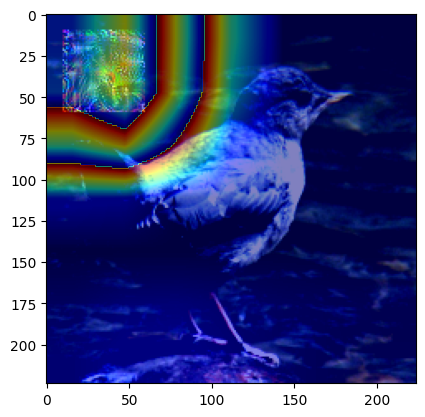

In [264]:
show_gradcam(model, model.layer4[1], adv_example.detach())

### TODO: make attention map animation